In [113]:
# Import Libraries
import pandas as pd
import numpy as np
import plotly.express as px
from plotly import graph_objs as go
from collections import Counter  
# For pre-processing
import re
import string
import nltk
from nltk.corpus import stopwords
import contractions
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from gensim.models import Word2Vec

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Reshape, LSTM, Bidirectional
from tensorflow.keras.layers import Input, TimeDistributed, Embedding, BatchNormalization
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Average
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Concatenate
import tensorflow.keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from wordcloud import WordCloud

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [2]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Z\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Z\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Import all datasets
data1 = pd.read_csv("dataset/tweets.txt",sep="\t", header=None, names=['id', 'sentiment', 'tweet','date_time'])[['tweet','sentiment']]
data2 = pd.read_csv("dataset/test_df.csv")[['tweet','sentiment']]
data3 = pd.read_csv("dataset/train_df.csv")[['tweet','sentiment']]

In [4]:
# Combine all imported data
data = pd.concat([data1,data2,data3])

In [5]:
# Drop irrelevant columns: id, date_time
# data = data.drop(columns=['id','date_time'])
data

tweet sentiment
0      Picturehouse's, Pink Floyd's, 'Roger Waters: T...   neutral
1      Order Go Set a Watchman in store or through ou...   neutral
2      If these runway renovations at the airport pre...  negative
3      If you could ask an onstage interview question...   neutral
4      A portion of book sales from our Harper Lee/Go...  positive
...                                                  ...       ...
53363  @Racalto_SK ok good to know. Punting at MetLif...  positive
53364  everyone who sat around me at metlife was so a...   neutral
53365  what giants or niners fans would wanna go to t...   neutral
53366  Anybody want a ticket for tomorrow Colombia vs...  positive
53367  Mendez told me he'd drive me to MetLife on Sun...   neutral

[97812 rows x 2 columns]

In [6]:
# Find the duplicates
duplicates = data[data.duplicated(subset=['tweet'], keep='first')]

# Find original tweets that were duplicated
originals = data[data.duplicated(subset=['tweet'], keep=False)].drop_duplicates(subset=['tweet'], keep='first')

# Combine original + duplicates
result = pd.concat([originals, duplicates]).sort_values(by='tweet')

# Drop the dupicated data
data = data.drop_duplicates(subset=['tweet'], keep='first')

In [7]:
data.describe().style.set_table_styles([{
    'selector': 'th',
    'props': [('background-color', '#F0F8FF'), ('color', 'Black')]
}])

In [8]:
data.groupby('sentiment').count()

tweet
sentiment       
negative   12216
neutral    29511
positive   22789

In [9]:
data.loc[:,'label'] = data['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

C:\Users\Z\AppData\Local\Temp\ipykernel_110992\2838974281.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'label'] = data['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})


In [10]:
sentiment_counts = data['sentiment'].value_counts()

# Define a function to assign colors to sentiment categories
def assign_color(sentiment):
    if sentiment == 'positive':
        return '#90EE90'
    elif sentiment == 'neutral':
        return '#66B2FF'
    elif sentiment == 'negative':
        return '#08306B'
    else:
        return 'gray'  # Default color for unknown sentiment

# Apply the color assignment function to each sentiment category
colors = [assign_color(sentiment) for sentiment in sentiment_counts.index]

fig = px.pie(
    values=sentiment_counts.values,
    names=sentiment_counts.index,
    title="Sentiment Distribution",
    color_discrete_sequence=colors  # Assign colors based on sentiment
)

fig.update_traces(textinfo='percent+label', pull=[0.03, 0.02], textfont=dict(size=18))  # Increase font size

fig.update_layout(
    showlegend=True,
    title_font=dict(size=22),  # Increase title font size
    width=800,  # Adjust the width of the figure
    height=600  # Adjust the height of the figure
)

fig.show()

In [11]:
sentiment_counts = data['sentiment'].value_counts()

# Define a function to assign colors to sentiment categories
def assign_color(sentiment):
    if sentiment == 'positive':
        return '#16C60C'
    elif sentiment == 'neutral':
        return '#0078D7'
    elif sentiment == 'negative':
        return '#F03A17'
    else:
        return 'gray'  # Default color for unknown sentiment

# Create a bar plot and apply the color function
fig = go.Figure([go.Bar(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    marker=dict(color=[assign_color(sent) for sent in sentiment_counts.index])
)])

# Set the layout
fig.update_layout(
    title="Sentiment Count",
    xaxis=dict(title="Sentiment"),
    yaxis=dict(title="Count"),
    width=800,  # Adjust the width of the figure
    height=600  # Adjust the height of the figure
)

fig.show()

In [12]:
# Create a figure with a Funnelarea chart
temp = data.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
fig = go.Figure(go.Funnelarea(
    text=temp.sentiment,
    values=temp.tweet,
    title={"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"},
    marker_colors=[assign_color(sent) for sent in temp.sentiment],  # Assign colors based on sentiment
))
# Set the layout
fig.update_layout(
    width=800,  # Adjust the width of the figure
    height=600  # Adjust the height of the figure
)
fig.show()

In [13]:
data['temp_list'] = data['tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in data['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

C:\Users\Z\AppData\Local\Temp\ipykernel_110992\488653920.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
fig = px.bar(
    temp, 
    x="count", 
    y="Common_words", 
    title='Common Words in Tweets', 
    width=700, 
    height=700,
    color='count',  # Set the color based on the count of common words
    color_continuous_scale='YlGnBu',  # Specify a color scale 
)
fig.update_layout(
    xaxis_title="Frequency",
    yaxis_title=None,  # Remove the y-axis title
    title_font=dict(size=40),  # Increase title font size
    font=dict(size=20),  # Increase general text font size
)


fig.update_xaxes(showgrid=False)  # Hide x-axis grid lines
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='lightgray')  # Show and style y-axis grid lines

fig.show()

In [15]:
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    '''
    This function cleans the text by performing the following steps:
    1. Remove text starting with '@' symbol and followed by any characters
    2. Remove text in square brackets.
    3. Expand contractions.
    4. Remove URLs.
    5. Remove HTML tags.
    6. Make text lowercase.
    7. Remove punctuation.
    8. Remove numbers and words containing numbers.
    9. Tokenize the text.
    10. Lemmatize words.
    11. Remove stopwords.
    12. Remove repeated words.
    13. Replace multiple spaces with a single space.
    14. Remove non-alphanumeric characters.
    15. Remove leading and trailing spaces.

    Args:
        text (str): Input text to be cleaned.

    Returns:
        str: Cleaned text.
    '''
    # Remove text starting with '@' symbol and followed by any characters
    text = re.sub(r'@\w+', '', text)
    
    # Expand contractions
    text = contractions.fix(text)
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Make text lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # Remove numbers and words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Tokenize the text
    words = text.split()
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words 
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Remove repeated words
    unique_words = []
    for word in words:
        if word not in unique_words:
            unique_words.append(word)
    text = ' '.join(unique_words)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Remove leading and trailing spaces
    text = text.strip()
    
    return text

In [16]:
data.loc[:,'clean_tweet'] = data['tweet'].apply(lambda x:clean_text(x))
data

C:\Users\Z\AppData\Local\Temp\ipykernel_110992\1099382370.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



tweet sentiment  label  \
0      Picturehouse's, Pink Floyd's, 'Roger Waters: T...   neutral      1   
1      Order Go Set a Watchman in store or through ou...   neutral      1   
2      If these runway renovations at the airport pre...  negative      0   
3      If you could ask an onstage interview question...   neutral      1   
4      A portion of book sales from our Harper Lee/Go...  positive      2   
...                                                  ...       ...    ...   
53363  @Racalto_SK ok good to know. Punting at MetLif...  positive      2   
53364  everyone who sat around me at metlife was so a...   neutral      1   
53365  what giants or niners fans would wanna go to t...   neutral      1   
53366  Anybody want a ticket for tomorrow Colombia vs...  positive      2   
53367  Mendez told me he'd drive me to MetLife on Sun...   neutral      1   

                                               temp_list  \
0      [Picturehouse's,, Pink, Floyd's,, 'Roger, Wate...   
1      [Order, Go, Set, a, Watchman, in, store, or, t...   
2      [If, these, runway, renovations, at, the, airp...   
3      [If, you, could, ask, an, onstage, interview, ...   
4      [A, portion, of, book, sales, from, our, Harpe...   
...                                                  ...   
53363  [@Racalto_SK, ok, good, to, know., Punting, at...   
53364  [everyone, who, sat, around, me, at, metlife, ...   
53365  [what, giants, or, niners, fans, would, wanna,...   
53366  [Anybody, want, a, ticket, for, tomorrow, Colo...   
53367  [Mendez, told, me, he'd, drive, me, to, MetLif...   

                                             clean_tweet  
0      picturehouses pink floyds roger water walll op...  
1      order go set watchman store website tuesday ge...  
2      runway renovation airport prevent seeing taylo...  
3      could ask onstage interview question miss usa ...  
4      portion book sale harper leego set watchman re...  
...                                                  ...  
53363  ok good know punting metlife december task hop...  
53364  everyone sat around metlife annoying let ruin ...  
53365  giant niner fan would want go sunday night gam...  
53366  anybody want ticket tomorrow colombia v peru m...  
53367    mendez told would drive metlife sunday reaction  

[64516 rows x 5 columns]

## After Preprocessing and cleaning

In [18]:
train_temp = data.copy()
train_temp['temp_list'] = data['clean_tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_temp['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(30))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

In [19]:
fig = px.treemap(temp, path=['Common_words'], values='count', title='Tree of Most Common Words', color='count')
fig.show()

In [20]:
#MosT common positive words
Positive_sent = train_temp[train_temp['sentiment']=='positive']
Negative_sent = train_temp[train_temp['sentiment']=='negative']
Neutral_sent = train_temp[train_temp['sentiment']=='neutral']
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

In [21]:
fig = px.bar(
    temp_positive, 
    x="count", 
    y="Common_words", 
    title='Most Commmon Positive Words', 
    width=700, 
    height=700,
    color='count',  # Set the color based on the count of common words
    color_continuous_scale='Greens',  # Specify a color scale 
)

fig.show()

In [22]:
#MosT common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

In [23]:
fig = px.bar(
    temp_negative, 
    x="count", 
    y="Common_words", 
    title='Most Common Negative Words', 
    width=700, 
    height=700,
    color='count',  # Set the color based on the count of common words
    color_continuous_scale='YlOrRd',  # Choose the 'YlGnBu' color scale
)

fig.show()

In [24]:
#MosT common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Blues')

In [25]:
fig = px.bar(
    temp_neutral, 
    x="count", 
    y="Common_words", 
    title='Most Common Neutral Words', 
    width=700, 
    height=700,
    color='count',  # Set the color based on the count of common words
    color_continuous_scale='Blues',  # Choose the 'YlGnBu' color scale
)

fig.show()

In [26]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False, stopwords = stopwords):
    stopwords = set(stopwords.words('english'))
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout() 

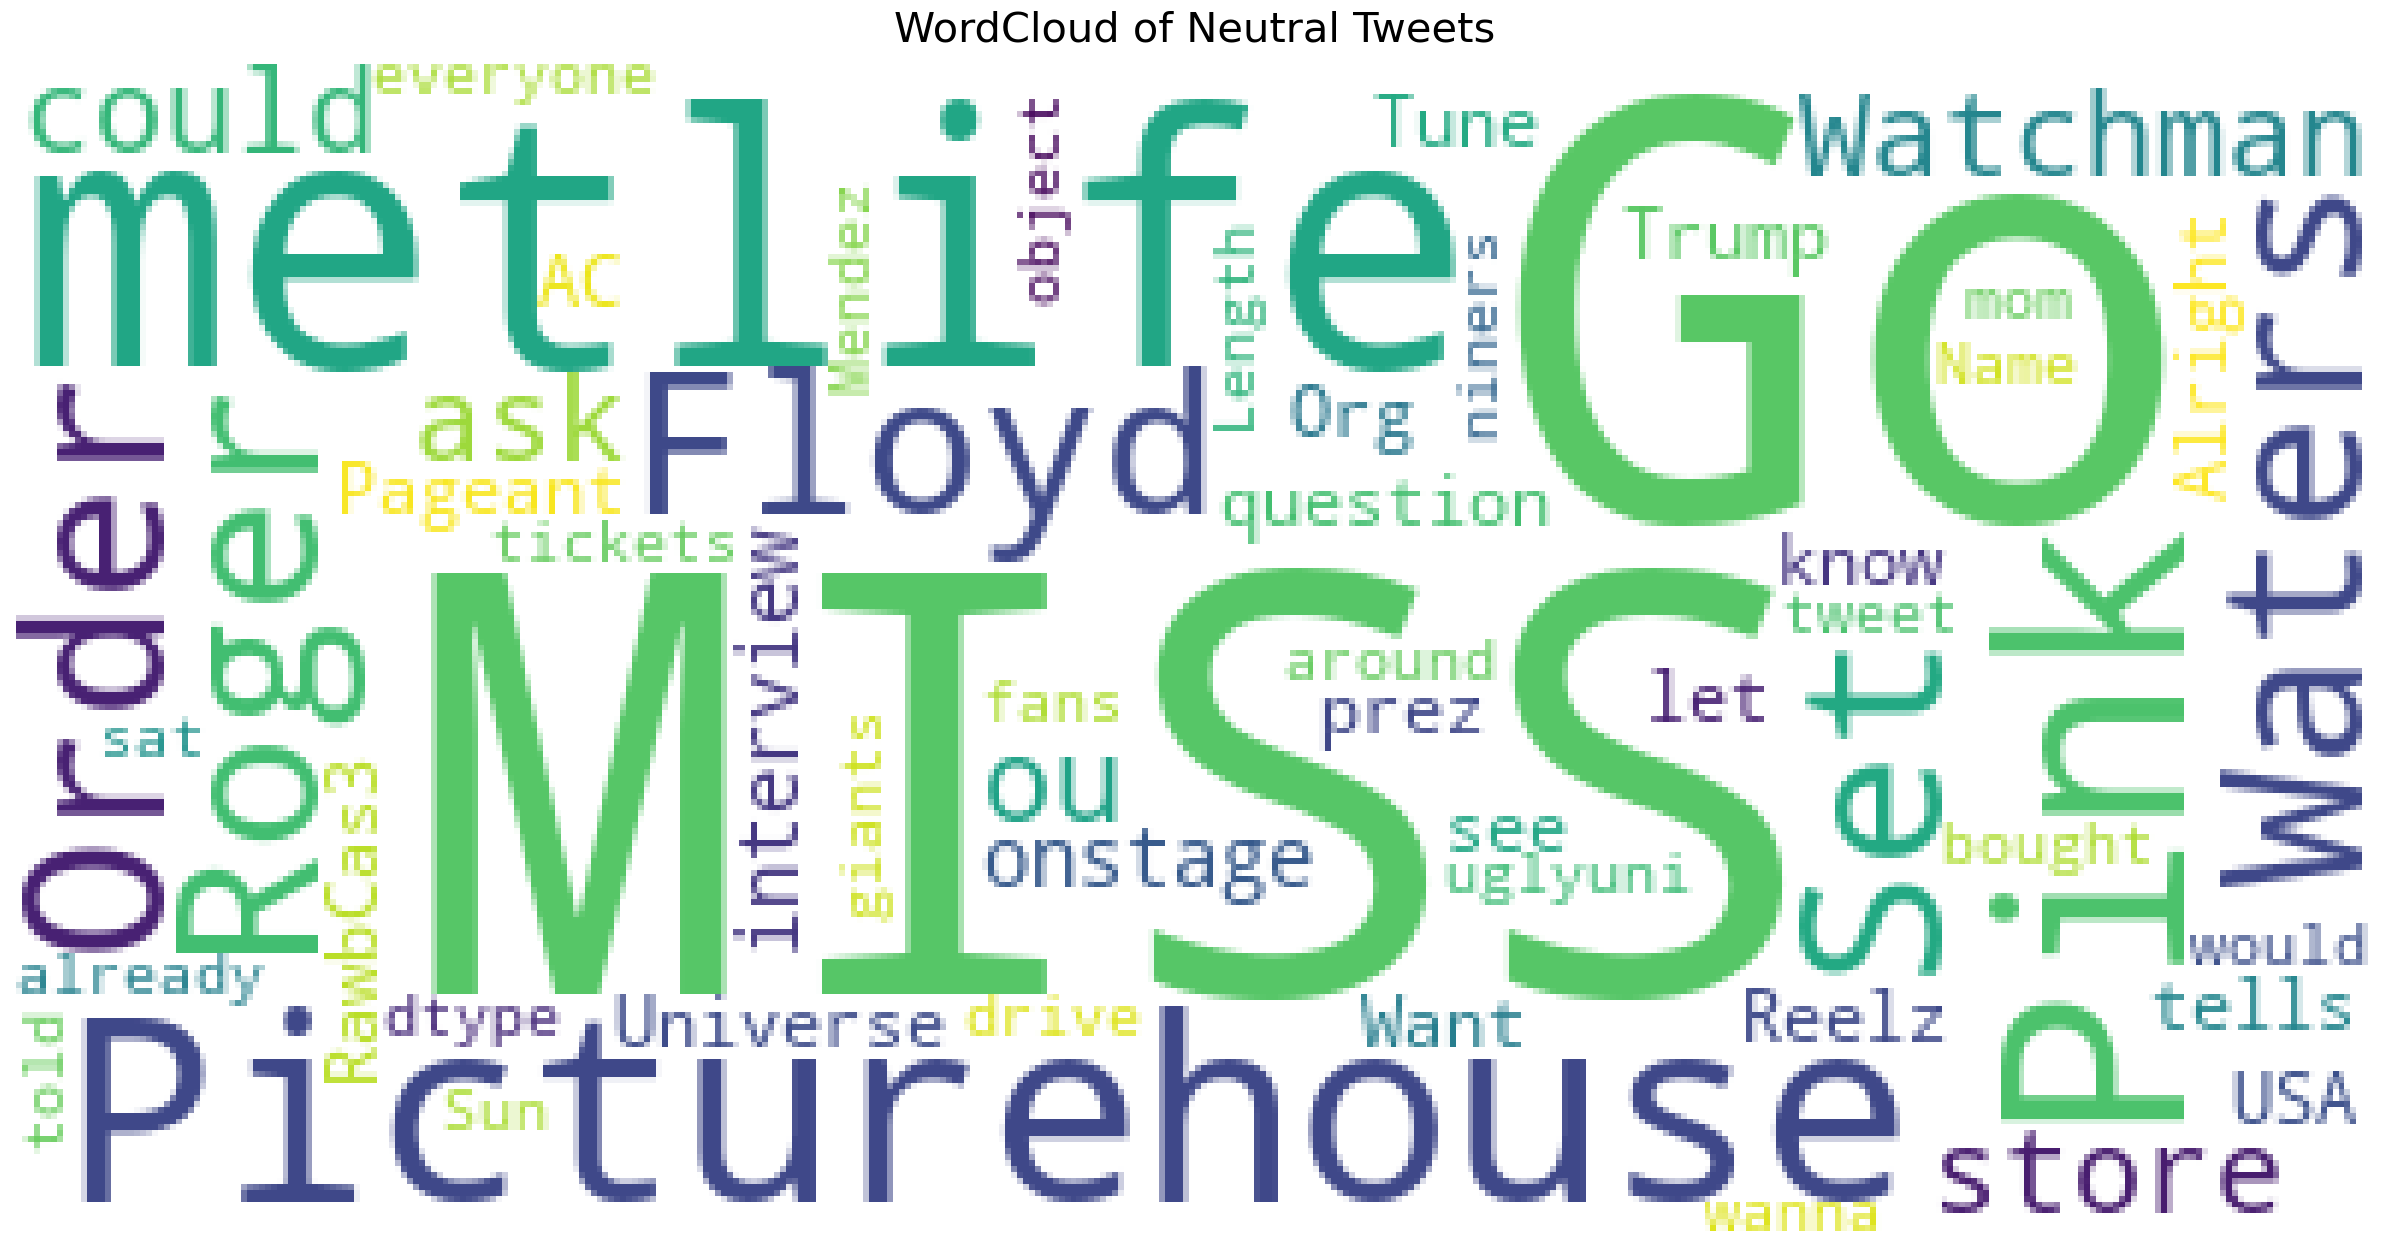

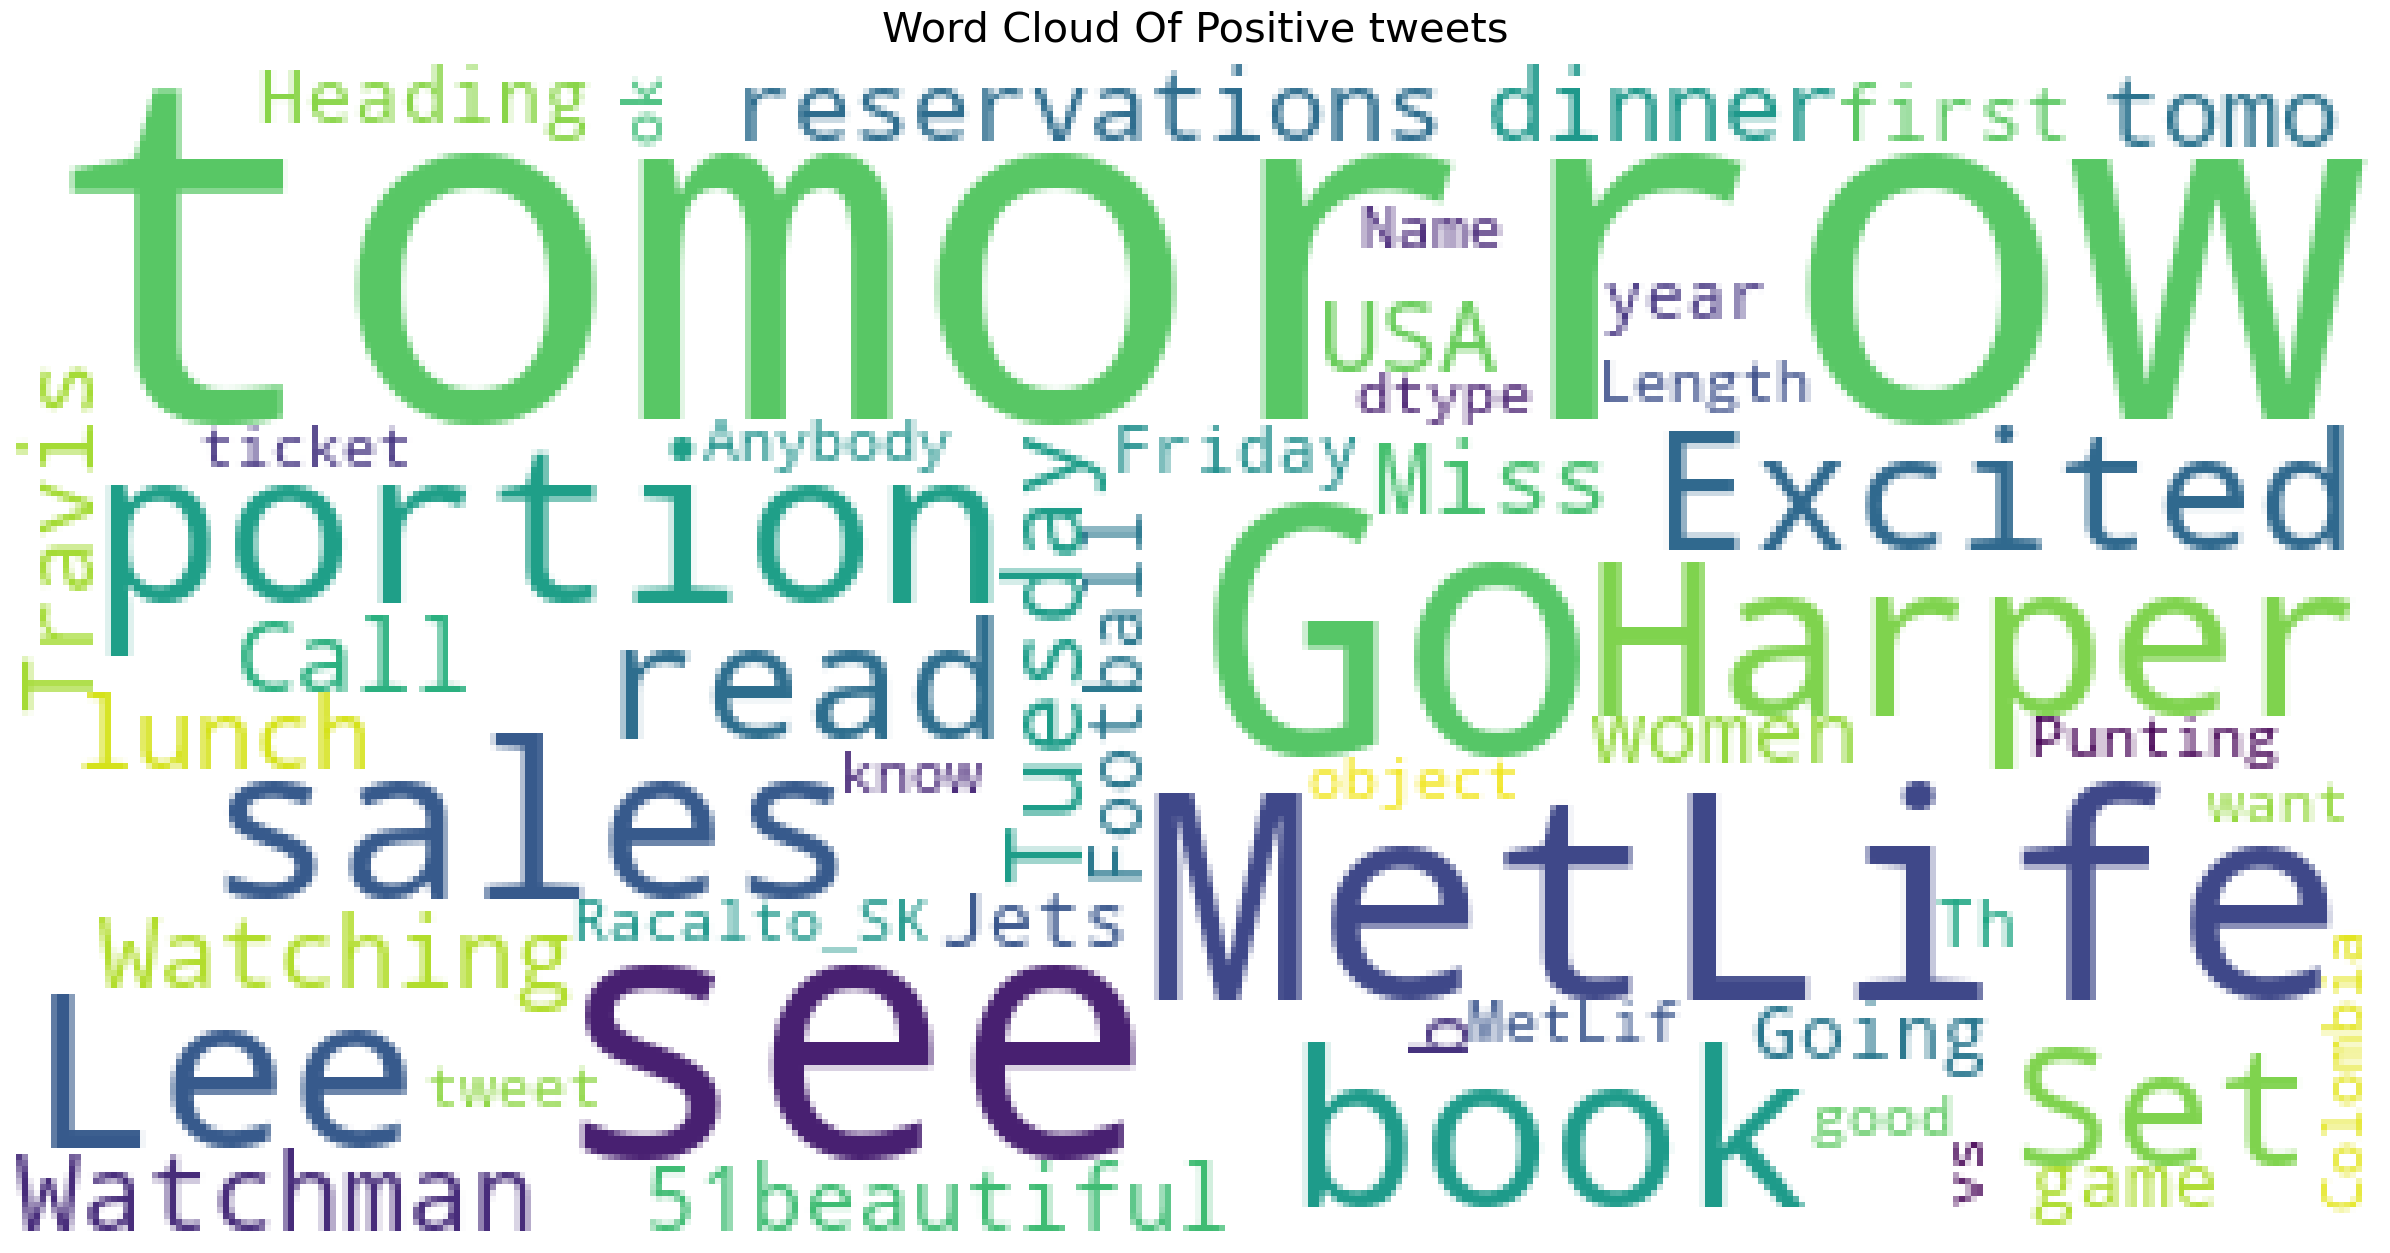

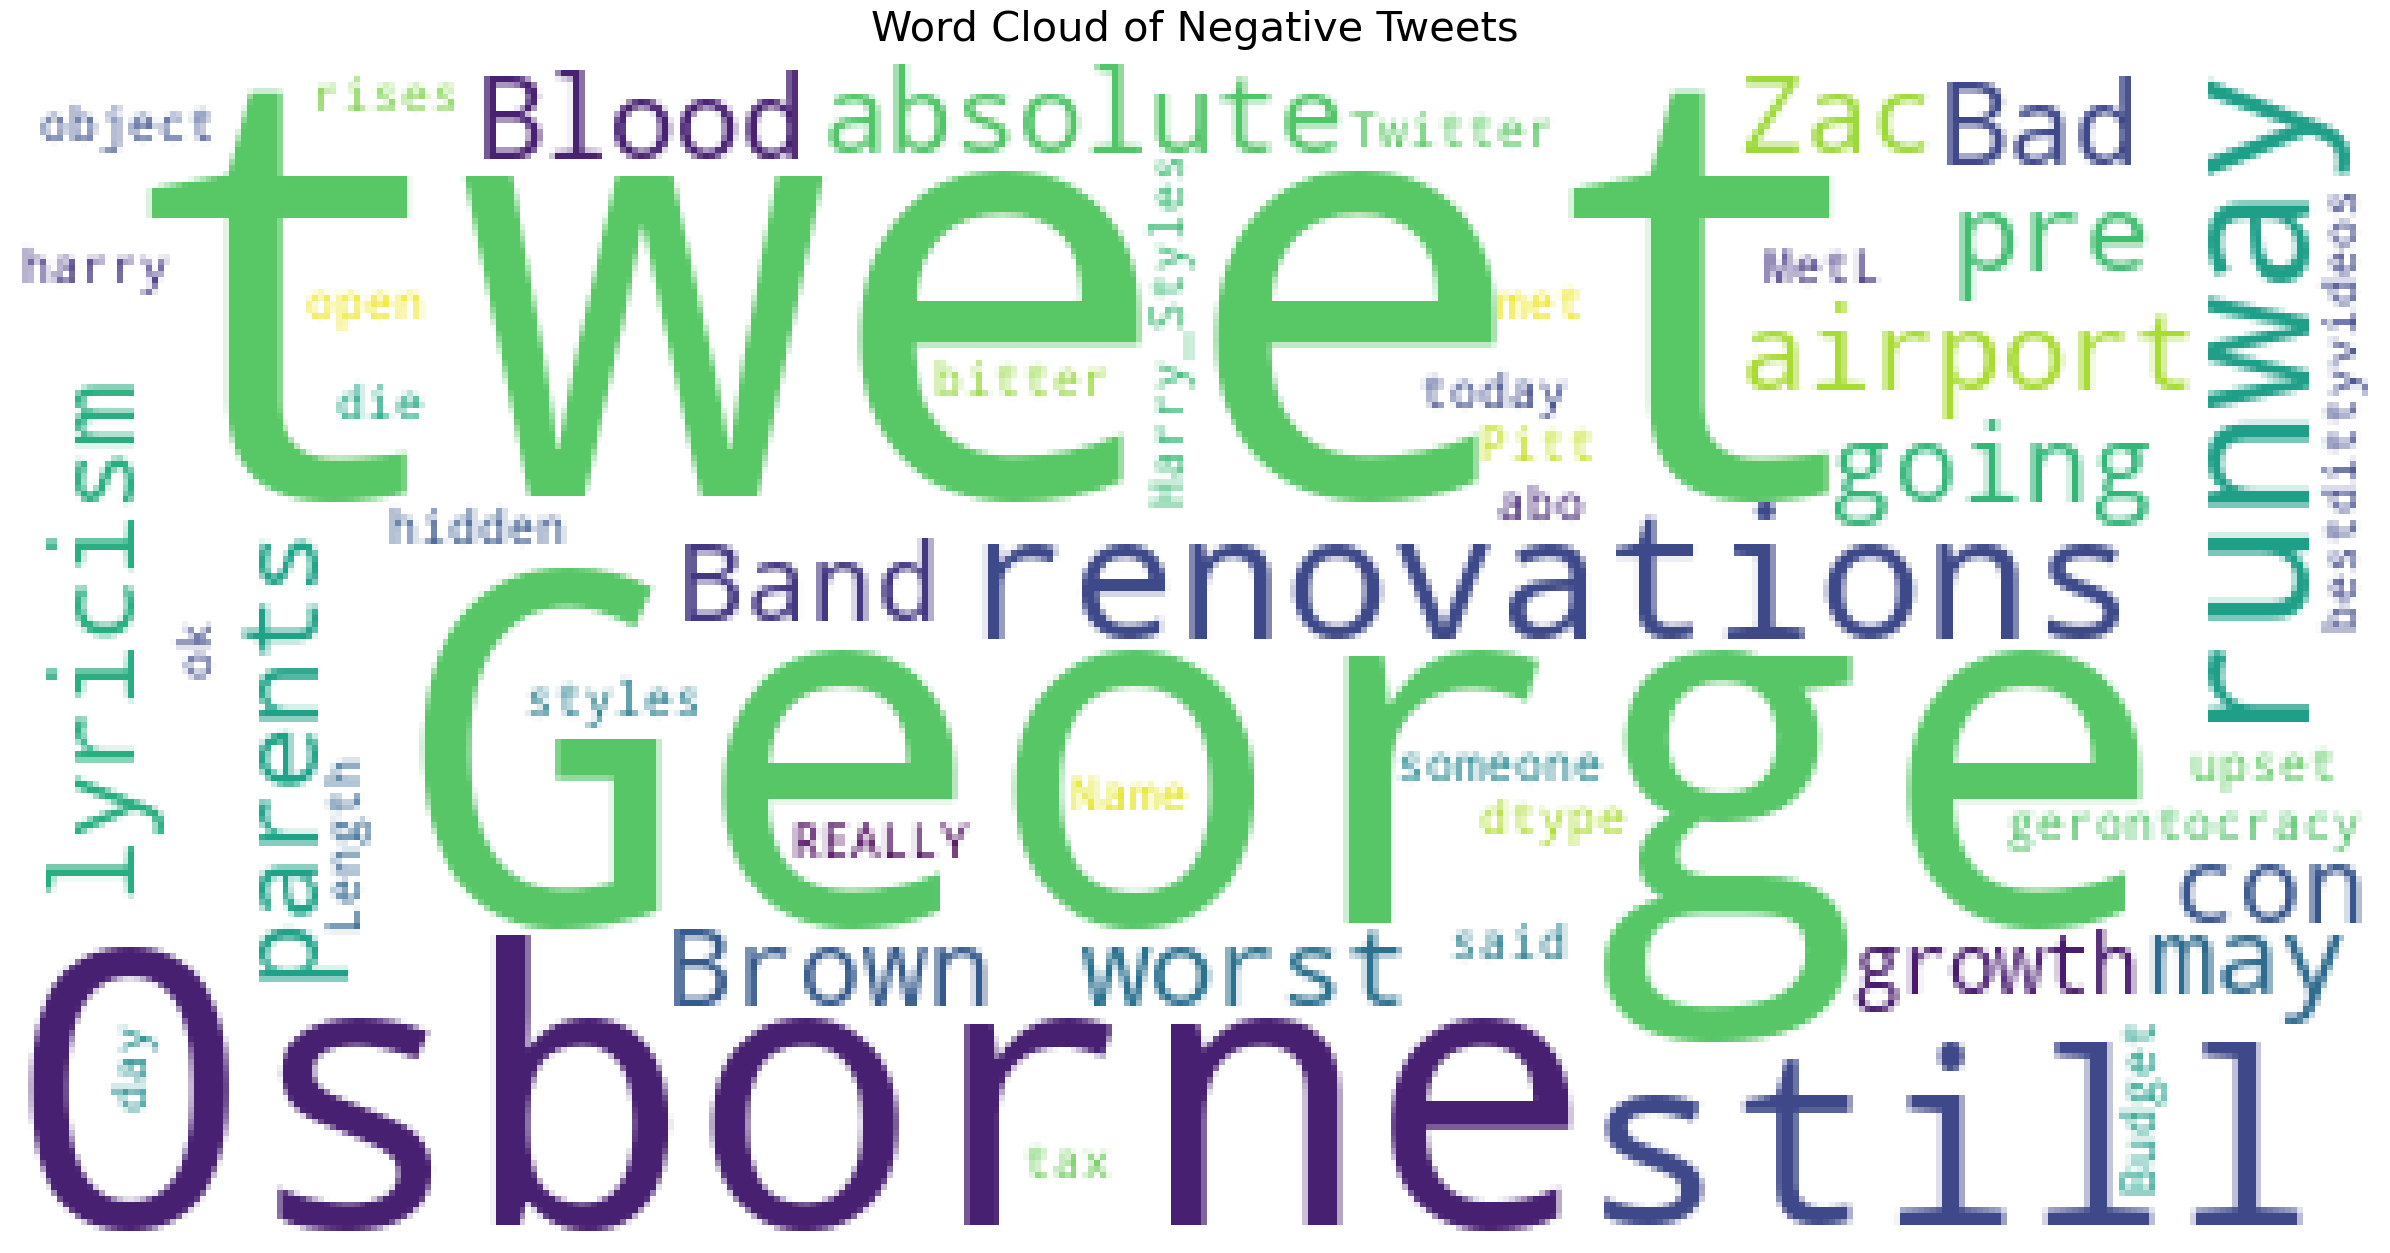

In [27]:
plot_wordcloud(Neutral_sent.tweet,color='white',max_font_size=100,title_size=30,title="WordCloud of Neutral Tweets")
plot_wordcloud(Positive_sent.tweet,title="Word Cloud Of Positive tweets",title_size=30)
plot_wordcloud(Negative_sent.tweet,title="Word Cloud of Negative Tweets",color='white',title_size=30)

In [28]:
X = data['clean_tweet']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
# Tokenize preprocessed tweets
tokenized_tweets = [tweet.split() for tweet in X_train]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_tweets, vector_size=25, window=5, min_count=5, sg=0)

# word_index = {word: i + 1 for i, word in enumerate(w2v_model.wv.index_to_key)}
# embedding_matrix = np.zeros((len(word_index) + 1, 25))
# for word, i in word_index.items():
#     if word in w2v_model.wv:
#         embedding_matrix[i] = w2v_model.wv[word]

In [30]:
def normalize_vector(vector):
    v_min = np.min(vector)
    v_max = np.max(vector)
    return (vector - v_min) / (v_max - v_min)

# Normalize Word2Vec vectors
normalized_w2v = {word: normalize_vector(w2v_model.wv.get_vector(word)) for word in w2v_model.wv.key_to_index}
# Normalize GloVe vectors
# normalized_glove = {word: normalize_vector(vector) for word, vector in glove_vectors.items()}

word_index = {word: i + 1 for i, word in enumerate(w2v_model.wv.index_to_key)}
embedding_matrix = np.zeros((len(word_index) + 1, 25))
for word, i in word_index.items():
    if word in normalized_w2v:
        embedding_matrix[i] = normalized_w2v[word]

In [31]:
def create_sentence_vector(sentence, word_vectors, max_length=40):
    words = sentence.split()
    sentence_vector = []
    for word in words[:max_length]:
        if word in word_vectors:
            sentence_vector.extend(word_vectors[word])
        else:
            sentence_vector.extend([0] * 25)  # Zero padding for unknown words
    
    # Pad or truncate to ensure fixed length
    if len(sentence_vector) < max_length * 25:
        sentence_vector.extend([0] * (max_length * 25 - len(sentence_vector)))
    else:
        sentence_vector = sentence_vector[:max_length * 25]
    
    return np.array(sentence_vector)


In [32]:
# def create_regional_sentence_vector(sentence, word_vectors, regions=8, words_per_region=10): # Has issues i think
#     words = sentence.split()
#     regional_vector = []
#     for i in range(regions):
#         region_words = words[i*words_per_region:(i+1)*words_per_region]
#         region_vector = []
#         for word in region_words:
#             if word in word_vectors:
#                 region_vector.extend(word_vectors[word])
#             else:
#                 region_vector.extend([0] * 25)  # Zero padding for unknown words
        
#         # Pad region if necessary
#         if len(region_vector) < words_per_region * 25:
#             region_vector.extend([0] * (words_per_region * 25 - len(region_vector)))
        
#         regional_vector.extend(region_vector)
    
#     return np.array(regional_vector)

# # Example usage
# # regional_vector_w2v = create_regional_sentence_vector("hello this is a sentence", normalized_w2v)
# # regional_vector_glove = create_regional_sentence_vector(sentence, normalized_glove)


In [33]:
def create_region_input(tweet, word_index, max_regions=8, region_size=10):
    regions = tweet.split('.')  # or split by punctuation if cleaner
    regions = [r.strip().split()[:region_size] for r in regions if r.strip()]
    
    while len(regions) < max_regions:
        regions.append([])

    region_array = np.zeros((max_regions, region_size), dtype=int)

    for i in range(min(len(regions), max_regions)):
        for j in range(len(regions[i])):
            word = regions[i][j]
            region_array[i][j] = word_index.get(word, 0)

    return region_array


In [34]:
%%time
X_train_regions = np.array([create_region_input(tweet, word_index) for tweet in X_train])
X_test_regions  = np.array([create_region_input(tweet, word_index) for tweet in X_test])

CPU times: total: 234 ms
Wall time: 670 ms


In [35]:
%%time
X_train_vectors = np.array([create_sentence_vector(tweet, w2v_model.wv) for tweet in X_train])
X_test_vectors  = np.array([create_sentence_vector(tweet, w2v_model.wv) for tweet in X_test])

CPU times: total: 4.86 s
Wall time: 10 s


In [36]:
# %%time
# X_train_regions = np.array([create_regional_sentence_vector(tweet, w2v_model.wv) for tweet in X_train])
# X_test_regions  = np.array([create_regional_sentence_vector(tweet, w2v_model.wv) for tweet in X_test])

In [37]:
# === Collect results ===
results = []

def log_model_result(name, y_true, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    results.append({
        'Model': name,
        'Recall': round(recall, 2),
        'Precision': round(prec, 2),
        'F1': round(f1, 2),
        'Accuracy': round(acc, 2)
    })

In [38]:
# Function to compile, train, and evaluate models
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name='Model', class_weight=None, loss='sparse_categorical_crossentropy'):
    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    # Train
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.1, class_weight=class_weight)

    # Predict class labels
    y_pred_probs = model.predict(X_test)
    y_pred = y_pred_probs.argmax(axis=1)

    # Log and show confusion matrix
    log_model_result(model_name, y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve (One-vs-Rest)
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):  # For each class
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
        plt.plot(fpr[i], tpr[i], label=f'{label} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

### 1) Single CNN network 

In [40]:
# Model 1: CNN only
# Non-Regional
def build_cnn_model():
    model = Sequential([
        Input(shape=(1000,)), Reshape((40, 25)),
        Conv1D(12, 3, activation='relu'),
        MaxPooling1D(3),
        Flatten(),
        Dense(3, activation='softmax')
    ])
    return model

# Regional
def build_region_cnn_model(embedding_matrix):
    input_layer = Input(shape=(8, 10))
    embed_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=25,
                            weights=[embedding_matrix], trainable=False)
    x = TimeDistributed(embed_layer)(input_layer)
    x = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    x = TimeDistributed(MaxPooling1D(2))(x)
    x = TimeDistributed(Flatten())(x)
    x = Flatten()(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

In [41]:
model_cnn_nr = build_cnn_model()
model_cnn_r = build_region_cnn_model(embedding_matrix)

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4692 - loss: 1.0339 - val_accuracy: 0.5195 - val_loss: 0.9621
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5268 - loss: 0.9548 - val_accuracy: 0.5371 - val_loss: 0.9408
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5350 - loss: 0.9388 - val_accuracy: 0.5387 - val_loss: 0.9336
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5458 - loss: 0.9302 - val_accuracy: 0.5404 - val_loss: 0.9312
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5467 - loss: 0.9264 - val_accuracy: 0.5418 - val_loss: 0.9273
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5439 - loss: 0.9265 - val_accuracy: 0.5485 - val_loss: 0.9237
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5543 - loss: 0.9169 - val_accuracy: 0.5494 - val_loss: 0.9210
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5481 - loss: 0.9201 - val_accu

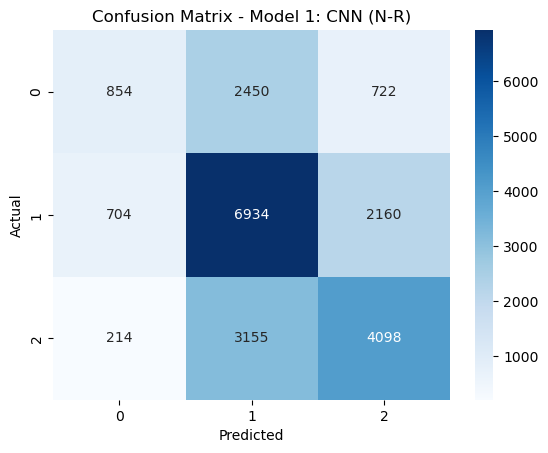

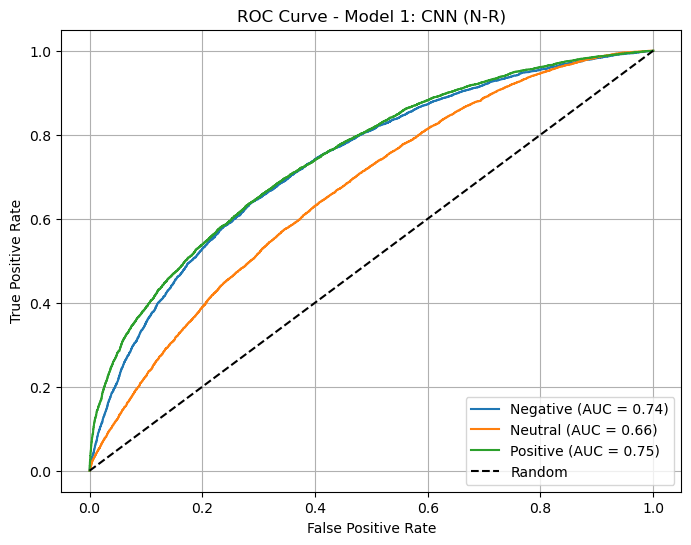

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.4677 - loss: 1.0280 - val_accuracy: 0.5117 - val_loss: 0.9793
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5112 - loss: 0.9716 - val_accuracy: 0.5121 - val_loss: 0.9623
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5175 - loss: 0.9608 - val_accuracy: 0.5232 - val_loss: 0.9503
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5266 - loss: 0.9511 - val_accuracy: 0.5276 - val_loss: 0.9454
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5257 - loss: 0.9459 - val_accuracy: 0.5316 - val_loss: 0.9434
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5256 - loss: 0.9422 - val_accuracy: 0.5302 - val_loss: 0.9420
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5281 - loss: 0.9435 - val_accuracy: 0.5344 - val_loss: 0.9390
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5327 - loss: 0.9410 - val_acc

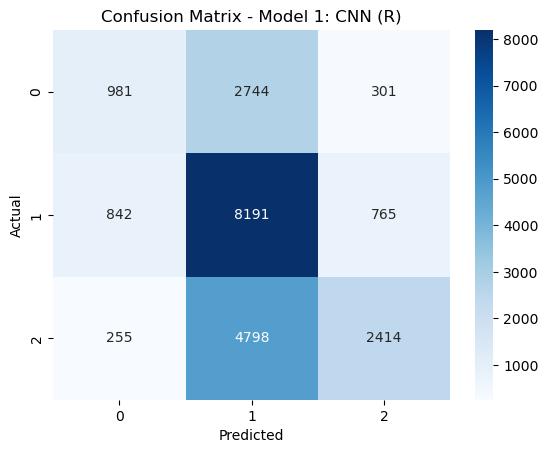

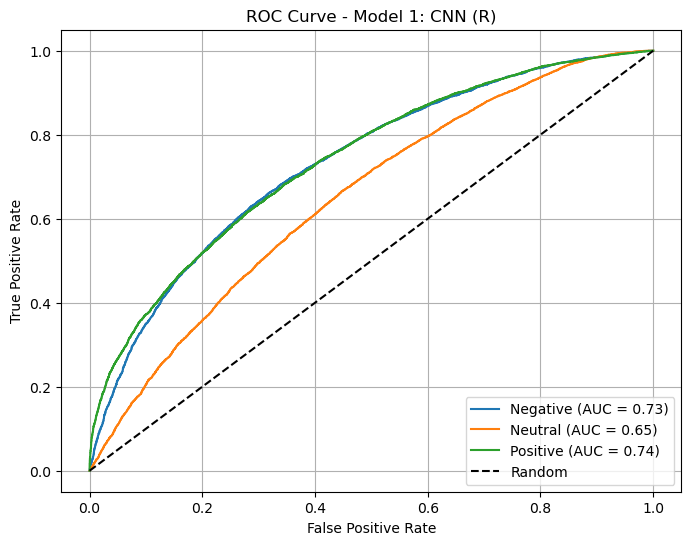

In [42]:
train_and_evaluate(model_cnn_nr, X_train_vectors, y_train, X_test_vectors, y_test, model_name='Model 1: CNN (N-R)')
train_and_evaluate(model_cnn_r, X_train_regions, y_train, X_test_regions, y_test, model_name='Model 1: CNN (R)')

### 2) Single LSTM network

In [44]:
# Model 2: LSTM only
# Non-Regional
def build_lstm_model():
    model = Sequential([
        Reshape((40, 25), input_shape=(1000,)),
        LSTM(64, dropout=0.2),
        Dense(3, activation='softmax')
    ])
    return model

# Regional
def build_region_lstm_model(embedding_matrix):
    input_layer = Input(shape=(8, 10))
    embed_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=25,
                            weights=[embedding_matrix], trainable=False)
    x = TimeDistributed(embed_layer)(input_layer)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64, dropout=0.2)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

In [45]:
model_lstm_nr = build_lstm_model()
model_lstm_r = build_region_lstm_model(embedding_matrix)

C:\Users\Z\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.4820 - loss: 1.0077 - val_accuracy: 0.5244 - val_loss: 0.9608
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5188 - loss: 0.9669 - val_accuracy: 0.5330 - val_loss: 0.9429
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5206 - loss: 0.9581 - val_accuracy: 0.5316 - val_loss: 0.9349
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.5218 - loss: 0.9486 - val_accuracy: 0.5369 - val_loss: 0.9421
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5245 - loss: 0.9471 - val_accuracy: 0.5473 - val_loss: 0.9255
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5332 - loss: 0.9408 - val_accuracy: 0.5563 - val_loss: 0.9196
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5334 - loss: 0.9357 - val_accuracy: 0.5452 - val_loss: 0.9165
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5363 - loss: 0

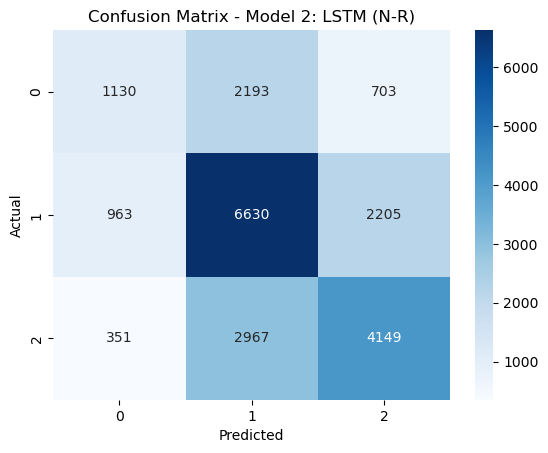

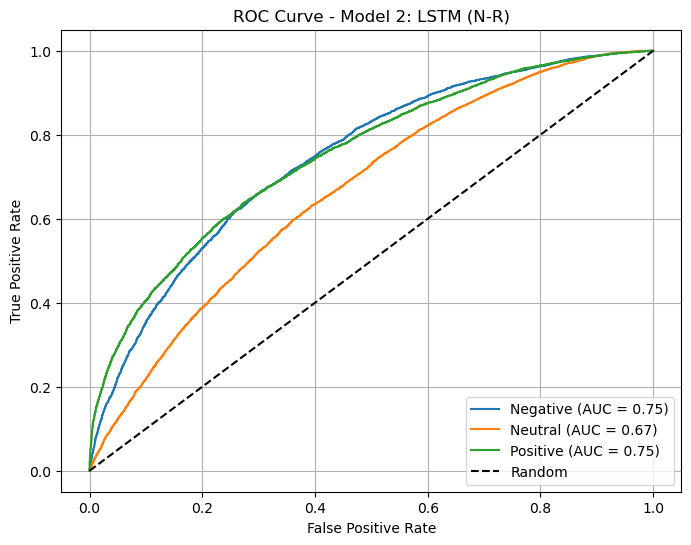

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4749 - loss: 1.0168 - val_accuracy: 0.4832 - val_loss: 0.9984
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5039 - loss: 0.9749 - val_accuracy: 0.5184 - val_loss: 0.9520
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5143 - loss: 0.9706 - val_accuracy: 0.5149 - val_loss: 0.9505
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.5121 - loss: 0.9685 - val_accuracy: 0.5154 - val_loss: 0.9557
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5154 - loss: 0.9650 - val_accuracy: 0.5302 - val_loss: 0.9436
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5128 - loss: 0.9673 - val_accuracy: 0.5168 - val_loss: 0.9473
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5232 - loss: 0.9572 - val_accuracy: 0.5195 - val_loss: 0.9494
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5156 - loss: 0.9606 - val_ac

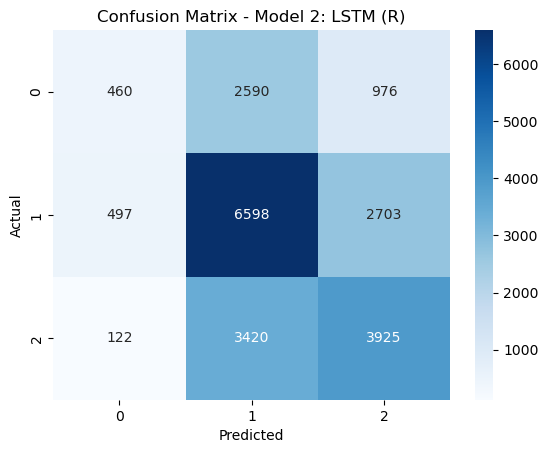

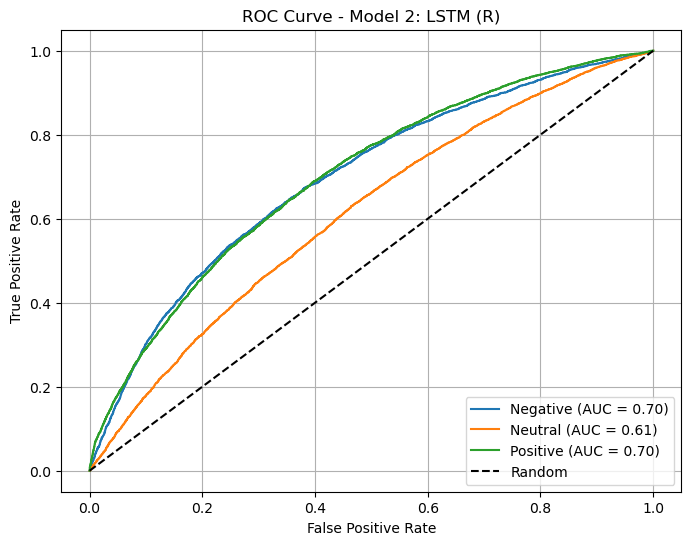

In [46]:
train_and_evaluate(model_lstm_nr, X_train_vectors, y_train, X_test_vectors, y_test, model_name='Model 2: LSTM (N-R)')
train_and_evaluate(model_lstm_r, X_train_regions, y_train, X_test_regions, y_test, model_name='Model 2: LSTM (R)')

### 3) Individual CNN and LSTM networks

In [48]:
# Model 3: CNN + LSTM
# Non-Regional
def build_cnn_lstm_model():
    input_layer = Input(shape=(1000,))
    reshaped = Reshape((40, 25))(input_layer)

    # CNN branch
    cnn = Conv1D(12, 3, activation='relu')(reshaped)
    cnn = MaxPooling1D(3)(cnn)
    cnn = Flatten()(cnn)
    cnn_out = Dense(3, activation='softmax')(cnn)

    # LSTM branch
    lstm = LSTM(64, dropout=0.2)(reshaped)
    lstm_out = Dense(3, activation='softmax')(lstm)

    # Combine with soft voting
    merged = Average()([cnn_out, lstm_out])
    model = Model(inputs=input_layer, outputs=merged)
    return model

# Regional
def build_region_cnn_lstm_model(embedding_matrix):
    input_layer = Input(shape=(8, 10))
    embed_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=25,
                            weights=[embedding_matrix], trainable=False)
    x = TimeDistributed(embed_layer)(input_layer)

    # CNN branch
    cnn = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    cnn = TimeDistributed(MaxPooling1D(2))(cnn)
    cnn = TimeDistributed(Flatten())(cnn)
    cnn = Flatten()(cnn)
    cnn_out = Dense(3, activation='softmax')(cnn)

    # LSTM branch
    lstm = TimeDistributed(Flatten())(x)
    lstm = LSTM(64, dropout=0.2)(lstm)
    lstm_out = Dense(3, activation='softmax')(lstm)

    # Soft voting
    merged = Average()([cnn_out, lstm_out])
    model = Model(inputs=input_layer, outputs=merged)
    return model

In [49]:
model_cnn_lstm_nr = build_cnn_lstm_model()
model_cnn_lstm_r = build_region_cnn_lstm_model(embedding_matrix)

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.4760 - loss: 1.0074 - val_accuracy: 0.5244 - val_loss: 0.9462
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5260 - loss: 0.9537 - val_accuracy: 0.5392 - val_loss: 0.9373
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5349 - loss: 0.9399 - val_accuracy: 0.5445 - val_loss: 0.9308
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5376 - loss: 0.9356 - val_accuracy: 0.5524 - val_loss: 0.9232
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.5429 - loss: 0.9338 - val_accuracy: 0.5381 - val_loss: 0.9295
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.5497 - loss: 0.9241 - val_accuracy: 0.5448 - val_loss: 0.9278
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.5475 - loss: 0.9223 - val_accuracy: 0.5542 - val_loss: 0.9180
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.5480 - loss: 0

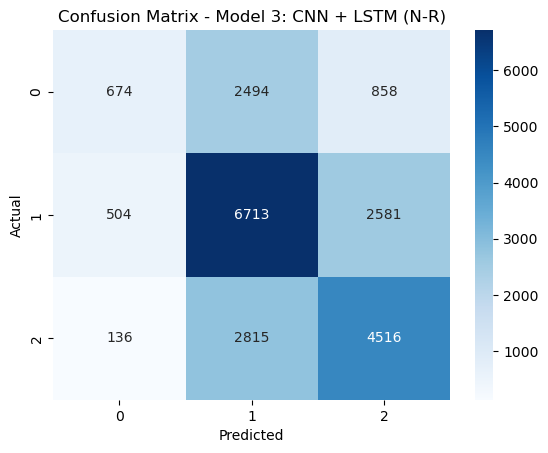

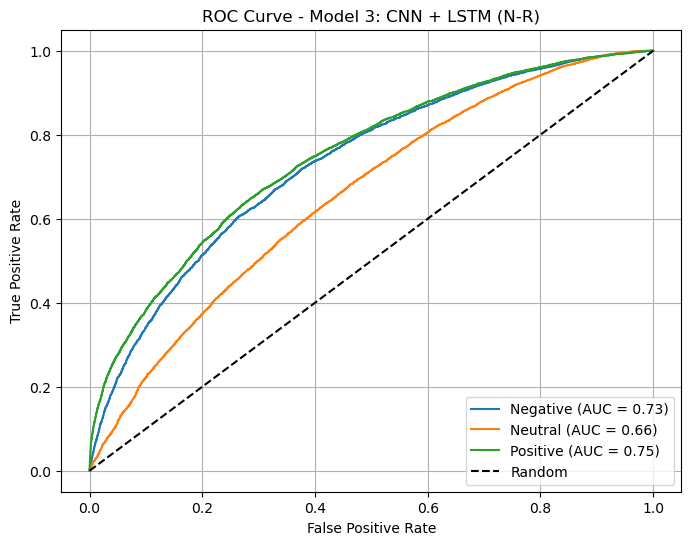

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.4629 - loss: 1.0217 - val_accuracy: 0.5154 - val_loss: 0.9643
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5197 - loss: 0.9636 - val_accuracy: 0.5124 - val_loss: 0.9618
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5205 - loss: 0.9584 - val_accuracy: 0.5147 - val_loss: 0.9486
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5228 - loss: 0.9500 - val_accuracy: 0.5288 - val_loss: 0.9399
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5290 - loss: 0.9454 - val_accuracy: 0.5339 - val_loss: 0.9363
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5243 - loss: 0.9473 - val_accuracy: 0.5323 - val_loss: 0.9341
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5334 - loss: 0.9384 - val_accuracy: 0.5244 - val_loss: 0.9408
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5333 - loss: 0.9366 -

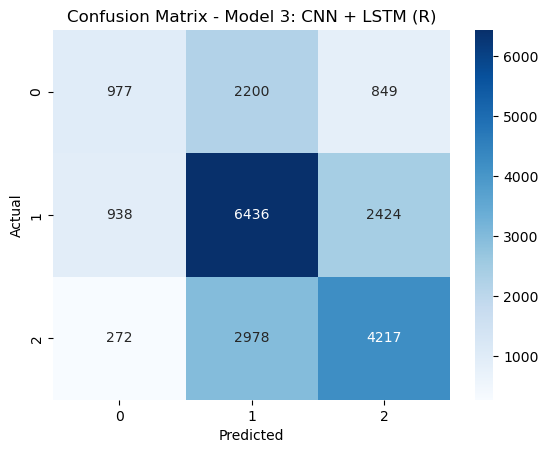

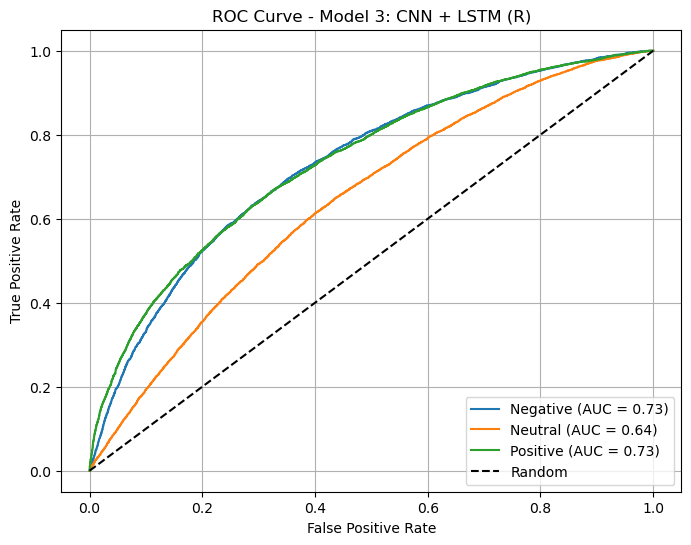

In [50]:
train_and_evaluate(model_cnn_lstm_nr, X_train_vectors, y_train, X_test_vectors, y_test, model_name='Model 3: CNN + LSTM (N-R)')
train_and_evaluate(model_cnn_lstm_r, X_train_regions, y_train, X_test_regions, y_test, model_name='Model 3: CNN + LSTM (R)')

### 4) Single 3-Layer CNN and LSTM Networks

In [52]:
# Model 4: 3-layer CNN + LSTM
# Non-Regional
def build_3_layer_cnn_lstm_model():
    model = Sequential([
        Reshape((40, 25), input_shape=(1000,)),
        Conv1D(12, 3, activation='relu'),
        Conv1D(12, 3, activation='relu'),
        Conv1D(12, 3, activation='relu'),
        MaxPooling1D(3),
        LSTM(64),
        Dense(3, activation='softmax')
    ])
    return model

# Regional
def build_3_layer_regioncnn_lstm_model(embedding_matrix):
    input_layer = Input(shape=(8, 10))
    embed_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=25,
                            weights=[embedding_matrix], trainable=False)
    x = TimeDistributed(embed_layer)(input_layer)
    x = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    x = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    x = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    x = TimeDistributed(MaxPooling1D(2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    return model


In [53]:
model_3cnn_lstm_nr = build_3_layer_cnn_lstm_model()
model_3cnn_lstm_r = build_3_layer_regioncnn_lstm_model(embedding_matrix)

C:\Users\Z\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.4868 - loss: 1.0117 - val_accuracy: 0.5286 - val_loss: 0.9477
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5265 - loss: 0.9460 - val_accuracy: 0.5394 - val_loss: 0.9293
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5429 - loss: 0.9294 - val_accuracy: 0.5457 - val_loss: 0.9213
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5485 - loss: 0.9210 - val_accuracy: 0.5466 - val_loss: 0.9182
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5530 - loss: 0.9183 - val_accuracy: 0.5487 - val_loss: 0.9184
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5526 - loss: 0.9121 - val_accuracy: 0.5533 - val_loss: 0.9193
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5537 - loss: 0.9069 - val_accuracy: 0.5582 - val_loss: 0.9099
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5651 - loss: 0.9023 - val

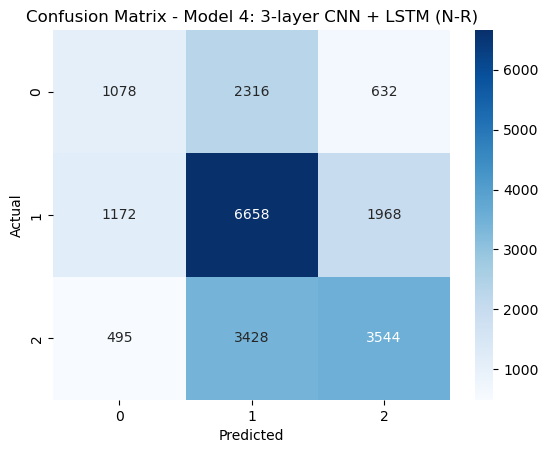

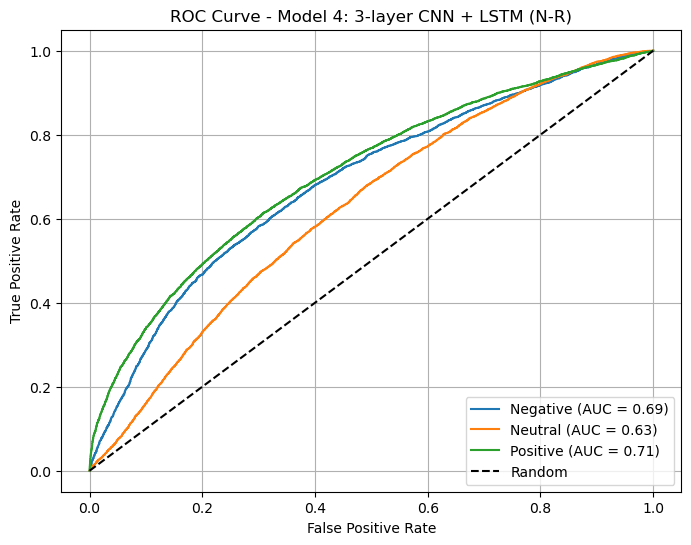

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.4686 - loss: 1.0261 - val_accuracy: 0.5084 - val_loss: 0.9718
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5055 - loss: 0.9702 - val_accuracy: 0.5124 - val_loss: 0.9669
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5141 - loss: 0.9683 - val_accuracy: 0.5073 - val_loss: 0.9801
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5180 - loss: 0.9604 - val_accuracy: 0.5237 - val_loss: 0.9593
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5269 - loss: 0.9522 - val_accuracy: 0.5244 - val_loss: 0.9584
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5244 - loss: 0.9502 - val_accuracy: 0.5274 - val_loss: 0.9435
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5313 - loss: 0.9429 - val_accuracy: 0.5193 - val_loss: 0.9495
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.5331 - loss: 0.9402

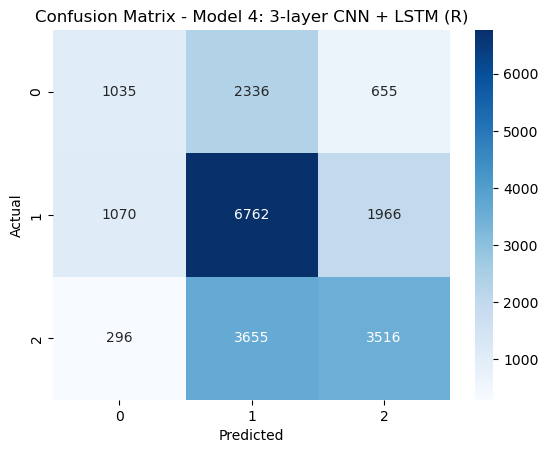

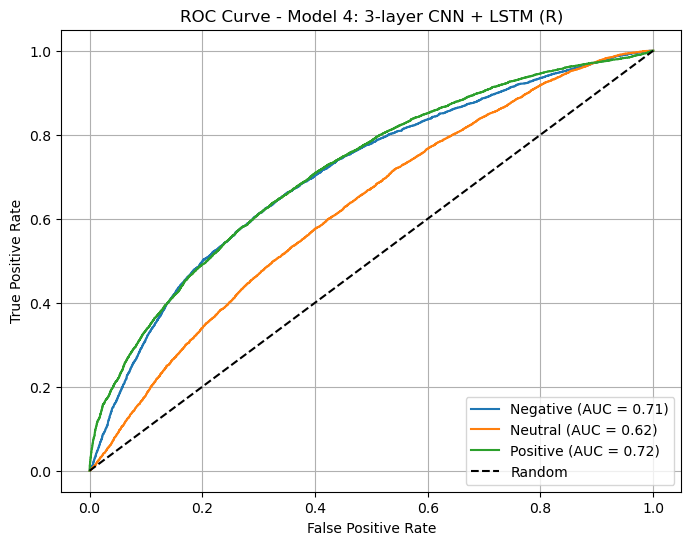

In [54]:
train_and_evaluate(model_3cnn_lstm_nr, X_train_vectors, y_train, X_test_vectors, y_test, model_name='Model 4: 3-layer CNN + LSTM (N-R)')
train_and_evaluate(model_3cnn_lstm_r, X_train_regions, y_train, X_test_regions, y_test, model_name='Model 4: 3-layer CNN + LSTM (R)')

### 5) Multiple CNN’s and LSTM Networks

In [115]:
# Model 5: Multiple CNNs (per word/region) + LSTM
# Non-Regional
def build_multi_cnn_lstm_model():
    non_regional_model = Sequential([
    Input(shape=(40, 25)),
    Reshape((40, 25, 1)),  # Add channel dimension
    TimeDistributed(Conv1D(12, 3, activation='relu')),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling1D(3)),
    TimeDistributed(Flatten()),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(3, activation='softmax')])
    return non_regional_model

#Regional
def build_regioncnn_lstm_model(embedding_matrix):
    input_layer = Input(shape=(8, 10))
    embed_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=25,
                            weights=[embedding_matrix], trainable=True)
    x = TimeDistributed(embed_layer)(input_layer)
    x = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling1D(2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(100, dropout=0.3, recurrent_dropout=0.2)(x)
    x = Dropout(0.3)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

In [117]:
model_multi_cnn_lstm_nr = build_multi_cnn_lstm_model()
model_multi_cnn_lstm_r = build_regioncnn_lstm_model(embedding_matrix)

In [118]:
print("Shape of X_train_vectors:", X_train_vectors.shape)
print("Shape of X_test_vectors:", X_test_vectors.shape)

Shape of X_train_vectors: (43225, 1000)
Shape of X_test_vectors: (21291, 1000)


In [119]:
X_train_vectors_reshaped = X_train_vectors.reshape(-1, 40, 25)
X_test_vectors_reshaped = X_test_vectors.reshape(-1, 40, 25)

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 89s 114ms/step - accuracy: 0.4853 - loss: 1.0060 - val_accuracy: 0.5300 - val_loss: 0.9978
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 62s 103ms/step - accuracy: 0.5279 - loss: 0.9590 - val_accuracy: 0.5281 - val_loss: 1.0238
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - accuracy: 0.5410 - loss: 0.9377 - val_accuracy: 0.5450 - val_loss: 0.9390
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 58s 95ms/step - accuracy: 0.5506 - loss: 0.9225 - val_accuracy: 0.4032 - val_loss: 0.9947
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 58s 95ms/step - accuracy: 0.5529 - loss: 0.9169 - val_accuracy: 0.5582 - val_loss: 0.9189
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 62s 102ms/step - accuracy: 0.5616 - loss: 0.9116 - val_accuracy: 0.5589 - val_loss: 0.9258
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 58s 96ms/step - accuracy: 0.5579 - loss: 0.9046 - val_accuracy: 0.5156 - val_loss: 0.9266
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 58s 95ms/step - accuracy: 0.5646 - los

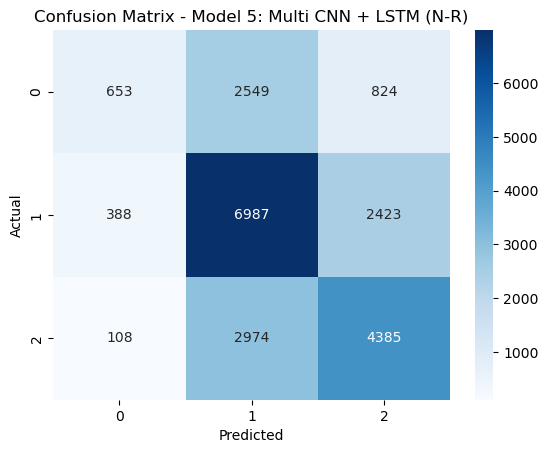

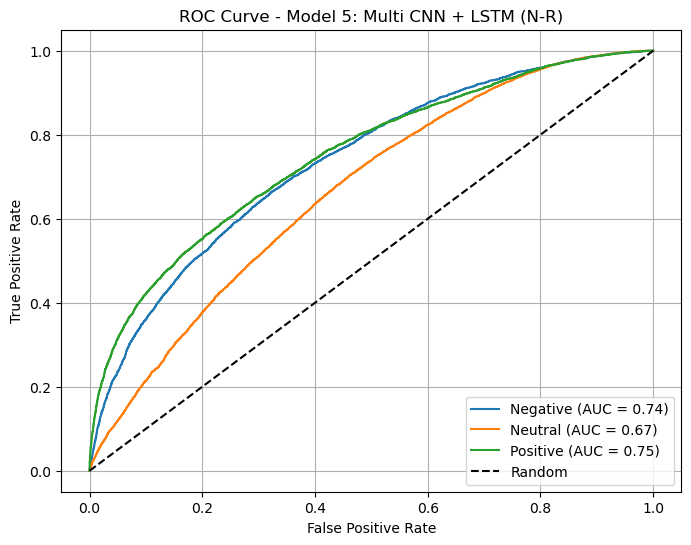

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.4932 - loss: 0.9896 - val_accuracy: 0.5586 - val_loss: 0.9034
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6164 - loss: 0.8294 - val_accuracy: 0.5906 - val_loss: 0.9014
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.6842 - loss: 0.7256 - val_accuracy: 0.6153 - val_loss: 0.8890
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7340 - loss: 0.6402 - val_accuracy: 0.5968 - val_loss: 1.0277
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.7704 - loss: 0.5669 - val_accuracy: 0.6010 - val_loss: 0.9579
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7913 - loss: 0.5173 - val_accuracy: 0.5961 - val_loss: 1.2041
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.8154 - loss: 0.4657 - val_accuracy: 0.5216 - val_loss: 1.3738
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8344 - loss: 0.42

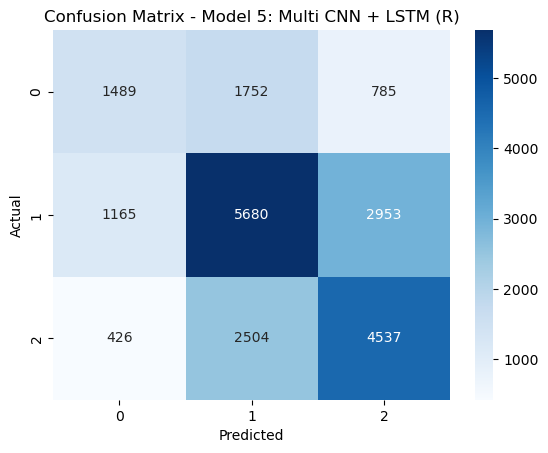

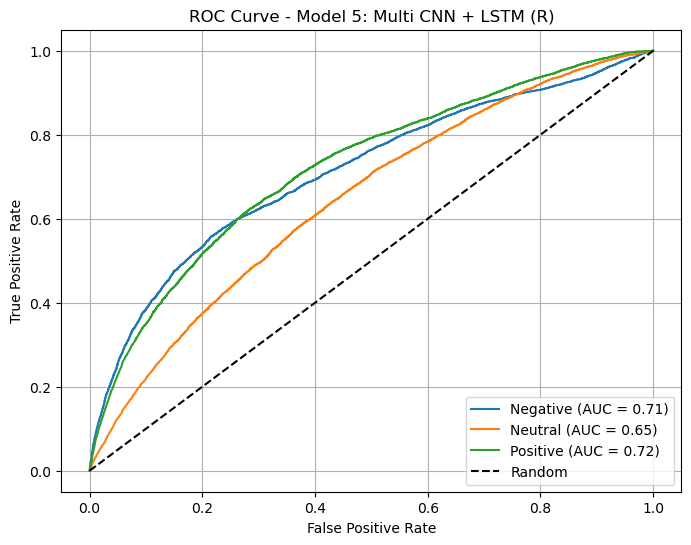

In [120]:
train_and_evaluate(model_multi_cnn_lstm_nr, X_train_vectors_reshaped, y_train, X_test_vectors_reshaped, y_test, model_name='Model 5: Multi CNN + LSTM (N-R)')
train_and_evaluate(model_multi_cnn_lstm_r, X_train_regions, y_train, X_test_regions, y_test, model_name='Model 5: Multi CNN + LSTM (R)')

### 6) Single 3-Layer CNN and bidirectional LSTM Network

In [86]:
# Model 6: 3-layer CNN + BiLSTM
# Non-Regional
def build_3_layer_cnn_bilstm_model():
    model = Sequential([
        Reshape((40, 25), input_shape=(1000,)),
        Conv1D(12, 3, activation='relu'),
        Conv1D(12, 3, activation='relu'),
        Conv1D(12, 3, activation='relu'),
        MaxPooling1D(3),
        Bidirectional(LSTM(64)),
        Dense(3, activation='softmax')
    ])
    return model

# Regional 
def build_3_layer_regioncnn_bilstm_model(embedding_matrix):
    input_layer = Input(shape=(8, 10))
    embed_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=25,
                            weights=[embedding_matrix], trainable=False)
    x = TimeDistributed(embed_layer)(input_layer)
    x = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    x = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    x = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    x = TimeDistributed(MaxPooling1D(2))(x)
    x = TimeDistributed(Flatten())(x)
    x = Bidirectional(LSTM(64))(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

In [87]:
model_3cnn_bilstm_nr = build_3_layer_cnn_bilstm_model()
model_3cnn_bilstm_r = build_3_layer_regioncnn_bilstm_model(embedding_matrix)

C:\Users\Z\anaconda3\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.4922 - loss: 0.9970 - val_accuracy: 0.5307 - val_loss: 0.9450
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5318 - loss: 0.9404 - val_accuracy: 0.5334 - val_loss: 0.9350
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5469 - loss: 0.9240 - val_accuracy: 0.5450 - val_loss: 0.9250
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5450 - loss: 0.9205 - val_accuracy: 0.5461 - val_loss: 0.9262
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5548 - loss: 0.9094 - val_accuracy: 0.5404 - val_loss: 0.9252
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5539 - loss: 0.9106 - val_accuracy: 0.5501 - val_loss: 0.9196
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5645 - loss: 0.9046 - val_accuracy: 0.5517 - val_loss: 0.9156
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5646 - loss: 0.9018 - val_acc

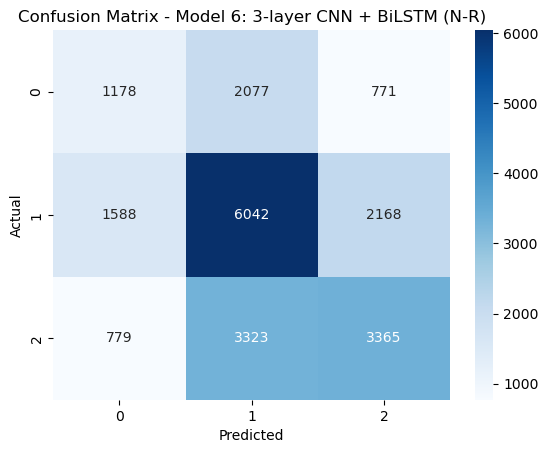

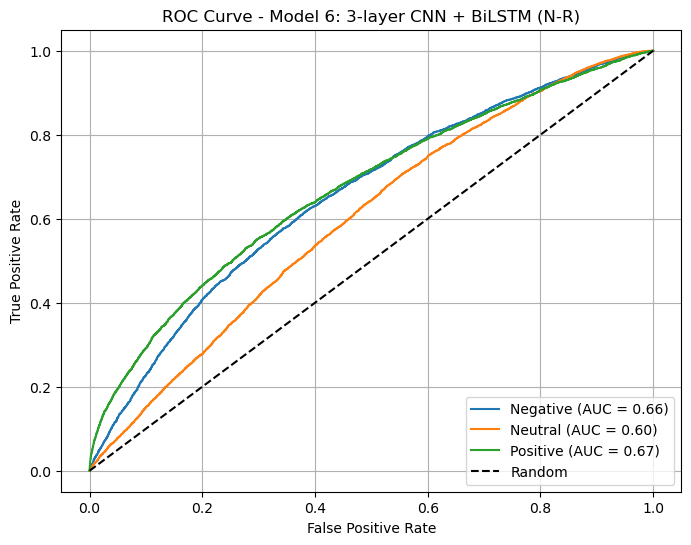

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - accuracy: 0.4765 - loss: 1.0178 - val_accuracy: 0.5163 - val_loss: 0.9731
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5082 - loss: 0.9765 - val_accuracy: 0.5156 - val_loss: 0.9635
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5164 - loss: 0.9632 - val_accuracy: 0.5263 - val_loss: 0.9569
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5232 - loss: 0.9539 - val_accuracy: 0.5207 - val_loss: 0.9542
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5324 - loss: 0.9484 - val_accuracy: 0.5202 - val_loss: 0.9522
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5316 - loss: 0.9403 - val_accuracy: 0.5288 - val_loss: 0.9425
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5390 - loss: 0.9356 - val_accuracy: 0.5348 - val_loss: 0.9445
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.5392 - loss: 0.9334 -

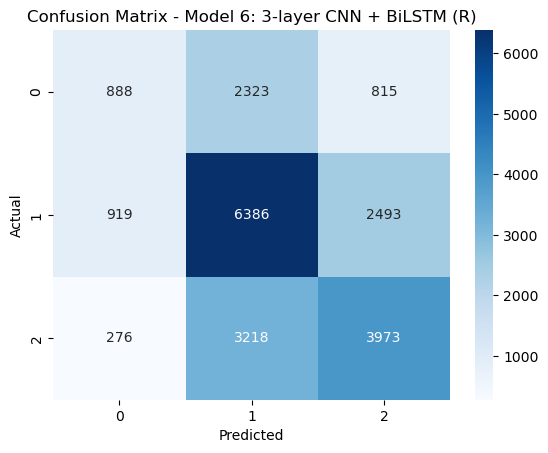

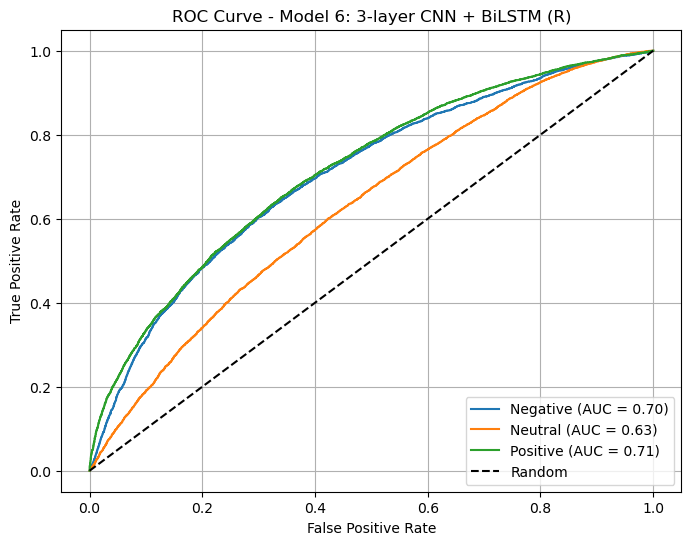

In [88]:
train_and_evaluate(model_3cnn_bilstm_nr, X_train_vectors, y_train, X_test_vectors, y_test, model_name='Model 6: 3-layer CNN + BiLSTM (N-R)')
train_and_evaluate(model_3cnn_bilstm_r, X_train_regions, y_train, X_test_regions, y_test, model_name='Model 6: 3-layer CNN + BiLSTM (R)')

### 7) Multiple CNN’s and bidirectional LSTM Network

In [103]:
# Model 7: Multiple CNNs + BiLSTM (Region-based BiLSTM)
# Regional
def build_regioncnn_bilstm_model(embedding_matrix):
    input_layer = Input(shape=(8, 10))
    embed_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=25,
                            weights=[embedding_matrix], trainable=False)
    x = TimeDistributed(embed_layer)(input_layer)
    x = TimeDistributed(Conv1D(12, 3, activation='relu'))(x)
    x = TimeDistributed(MaxPooling1D(2))(x)
    x = TimeDistributed(Flatten())(x)
    x = Bidirectional(LSTM(64,dropout=0.2))(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output)
    return model

#Non-Regional
def build_multi_cnn_bilstm_model():
    non_regional_model = Sequential([
    Input(shape=(40, 25)),
    Reshape((40, 25, 1)),  # Add channel dimension
    TimeDistributed(Conv1D(12, 3, activation='relu')),
    TimeDistributed(MaxPooling1D(3)),
    TimeDistributed(Flatten()),
    Bidirectional(LSTM(64,dropout=0.2)),
    Dense(3, activation='softmax')])
    return non_regional_model

In [105]:
model_multi_cnn_bilstm_nr = build_multi_cnn_bilstm_model()
model_multi_cnn_bilstm_r = build_regioncnn_bilstm_model(embedding_matrix)

In [107]:
X_train_vectors_reshaped = X_train_vectors.reshape((-1, 40, 25))
X_test_vectors_reshaped = X_test_vectors.reshape((-1, 40, 25))

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.4970 - loss: 0.9957 - val_accuracy: 0.5184 - val_loss: 0.9582
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.5229 - loss: 0.9570 - val_accuracy: 0.5471 - val_loss: 0.9297
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.5334 - loss: 0.9432 - val_accuracy: 0.5478 - val_loss: 0.9263
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.5371 - loss: 0.9356 - val_accuracy: 0.5540 - val_loss: 0.9133
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.5449 - loss: 0.9232 - val_accuracy: 0.5660 - val_loss: 0.9088
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.5469 - loss: 0.9186 - val_accuracy: 0.5600 - val_loss: 0.9039
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 35s 58ms/step - accuracy: 0.5484 - loss: 0.9160 - val_accuracy: 0.5688 - val_loss: 0.8993
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 35s 57ms/step - accuracy: 0.5547 - loss: 0

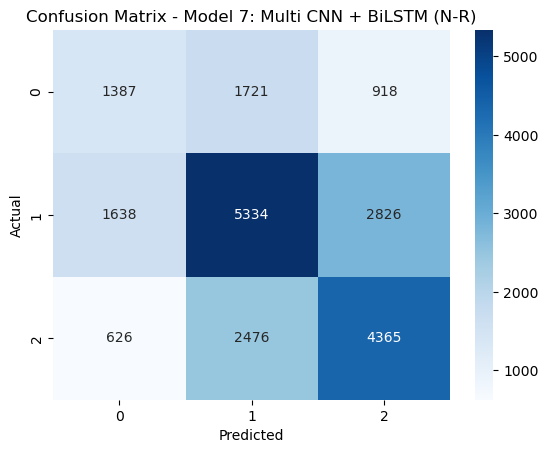

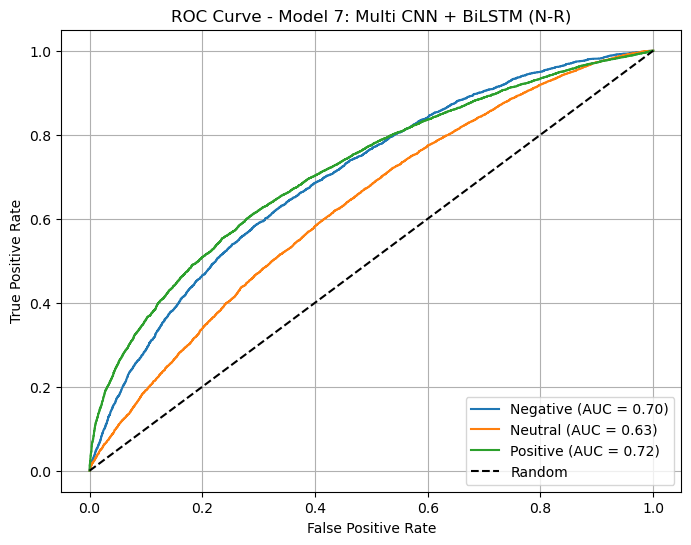

Epoch 1/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.4797 - loss: 1.0107 - val_accuracy: 0.5117 - val_loss: 0.9784
Epoch 2/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5141 - loss: 0.9705 - val_accuracy: 0.5207 - val_loss: 0.9613
Epoch 3/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5203 - loss: 0.9583 - val_accuracy: 0.5249 - val_loss: 0.9477
Epoch 4/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5269 - loss: 0.9517 - val_accuracy: 0.5274 - val_loss: 0.9603
Epoch 5/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5306 - loss: 0.9443 - val_accuracy: 0.5309 - val_loss: 0.9415
Epoch 6/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5348 - loss: 0.9431 - val_accuracy: 0.5288 - val_loss: 0.9421
Epoch 7/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5292 - loss: 0.9457 - val_accuracy: 0.5360 - val_loss: 0.9343
Epoch 8/100
608/608 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.5350 - loss: 0.9340 - val

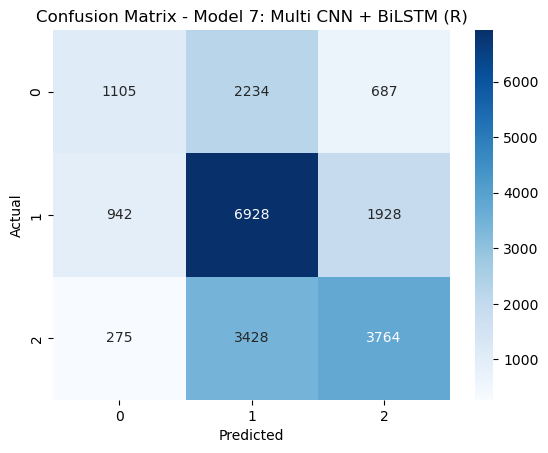

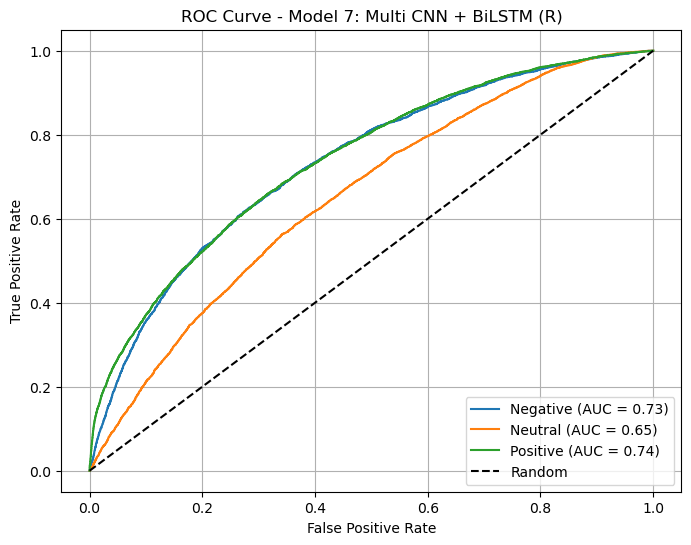

In [108]:
train_and_evaluate(model_multi_cnn_bilstm_nr, X_train_vectors_reshaped, y_train, X_test_vectors_reshaped, y_test, model_name='Model 7: Multi CNN + BiLSTM (N-R)')
train_and_evaluate(model_multi_cnn_bilstm_r, X_train_regions, y_train, X_test_regions, y_test, model_name='Model 7: Multi CNN + BiLSTM (R)')

In [131]:
results_df = pd.DataFrame(results)
print("=== Summary Table ===")
print(results_df.to_markdown(index=False))

=== Summary Table ===
| Model                               |   Recall |   Precision |   F1 |   Accuracy |
|:------------------------------------|---------:|------------:|-----:|-----------:|
| Model 1: CNN (N-R)                  |     0.49 |        0.54 | 0.49 |       0.56 |
| Model 1: CNN (R)                    |     0.47 |        0.56 | 0.47 |       0.54 |
| Model 2: LSTM (N-R)                 |     0.5  |        0.54 | 0.51 |       0.56 |
| Model 2: LSTM (R)                   |     0.44 |        0.49 | 0.43 |       0.52 |
| Model 3: CNN + LSTM (N-R)           |     0.49 |        0.55 | 0.48 |       0.56 |
| Model 3: CNN + LSTM (R)             |     0.49 |        0.52 | 0.49 |       0.55 |
| Model 4: 3-layer CNN + LSTM (N-R)   |     0.47 |        0.5  | 0.48 |       0.53 |
| Model 4: 3-layer CNN + LSTM (R)     |     0.47 |        0.51 | 0.48 |       0.53 |
| Model 5: Multi CNN + LSTM (N-R)     |     0.49 |        0.57 | 0.49 |       0.56 |
| Model 5: Multi CNN + LSTM (R)       |    